# Spatial Interpolation - Part 2

<br>



<br>

## Analysis Preparation

### Imports

All of these libraries should have been previously installed during the environment set-up, if they have not been installed already you can use ```install.packages(c("raster", "rgdal", "ape", "scales", "deldir", "gstat"))```

In [1]:
library(raster) # rasters
library(rgdal)  # spatial data
library(sf)     # for handling spatial features
library(ape)    # clustering (Morans I)
library(scales) # transparencies
library(deldir) # triangulation
library(gstat)  # geostatistics

source('../scripts/helpers.R') # helper script, note that '../' is used to change into the directory above the directory this notebook is in

Loading required package: sp

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.4, released 2020/10/20
Path to GDAL shared files: /srv/conda/envs/notebook/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.1.1, September 1st, 2020, [PJ_VERSION: 711]
Path to PROJ shared files: /srv/conda/envs/notebook/share/proj
PROJ CDN enabled: TRUE
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Linking to GEOS 3.8.1, GDAL 3.1.4, PROJ 7.1.1


Attaching package: ‘ape’


The following objects are masked from ‘package:raster’:

    rotate, zoom


deldir 0.2-3      Nickname: "Stack Smashing Detected"


     Note 1: As of version 0.2-1, error handling in this 
     package was amended to conform to the usual R protocol. 
     The deldir() function now actually thro

<br>

### Loading Data

We'll start by again checking to see if we need to download any data.

In [2]:
download_data()

<br>

We'll then load in the datasets.

In [3]:
df_zambia <- read_sf('../data/zambia/zambia.shp')
df_africa_cities <- read_sf('../data/africa/cities.shp')
solar <- raster('../data/zambia/solar.tif')
altitude <- raster('../data/zambia/altitude.tif')

<br>

Do some pre-processing on the zambian cities dataset (which we'll use as points in our Voronoi diagram later).

In [4]:
df_zambian_cities <- df_africa_cities[which(df_africa_cities$COUNTRY=='Zambia'), ]
df_zambian_cities_UTM35S <- st_transform(df_zambian_cities, crs=st_crs(20935))

head(df_zambian_cities_UTM35S, 3)

LATLONGID LATITUDE  LONGITUDE URBORRUR YEAR ES90POP ES95POP ES00POP INSGRUSED
1 4         -12.65000 28.08333  U        1990   9945   10684   11218  N        
2 7         -12.36667 27.83333  U        1990  48055   51629   54206  N        
3 9         -12.53333 27.85000  U        1990 142383  152972  160610  N        
  CONTINENT ⋯ SCHADMNM   ADMNM1     ADMNM2        TYPE SRCTYP    COORDSRCE
1 Africa    ⋯ COPPERBELT Copperbelt Kalulushi     UA   Published NIMA     
2 Africa    ⋯ COPPERBELT Copperbelt Chililabombwe UA   Published NIMA     
3 Africa    ⋯ COPPERBELT Copperbelt Chingola      UA   Published NIMA     
  DATSRC                                                              
1 Census of Population, Housing & Argriculture 1990 Descriptive Tables
2 Census of Population, Housing & Argriculture 1990 Descriptive Tables
3 Census of Population, Housing & Argriculture 1990 Descriptive Tables
  LOCNDATSRC             NOTES geometry                
1 UN Statistical Library NA    POINT (617646.2 8601614)
2 UN Statistical Library NA    POINT (590593.6 8633048)
3 UN Statistical Library NA    POINT (592346.6 8614610)

<br>

We'll visualise these as well

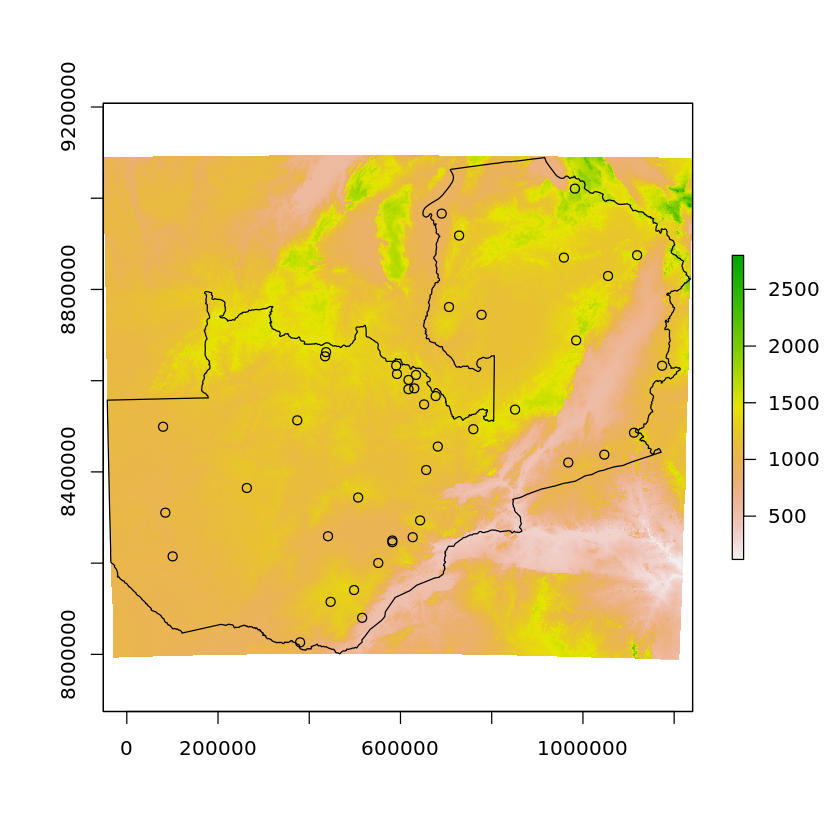

In [5]:
plot(altitude)
plot(df_zambia['geometry'], add=TRUE)
plot(df_zambian_cities_UTM35S['geometry'], add=TRUE)

<br>

### Interpolation

First we'll extract the solar and altitude values for the points we've selected (just so happens to be cities in this case).

In [6]:
city_coords = st_coordinates(df_zambian_cities_UTM35S)

df_zambian_cities_UTM35S$solar <- extract(solar, city_coords)
df_zambian_cities_UTM35S$altitude <- extract(altitude, city_coords)

df_zambian_cities_UTM35S$x <- city_coords[, 1]
df_zambian_cities_UTM35S$y <- city_coords[, 2]

<br>

We'll now create a grid that we will carry out the predictions over

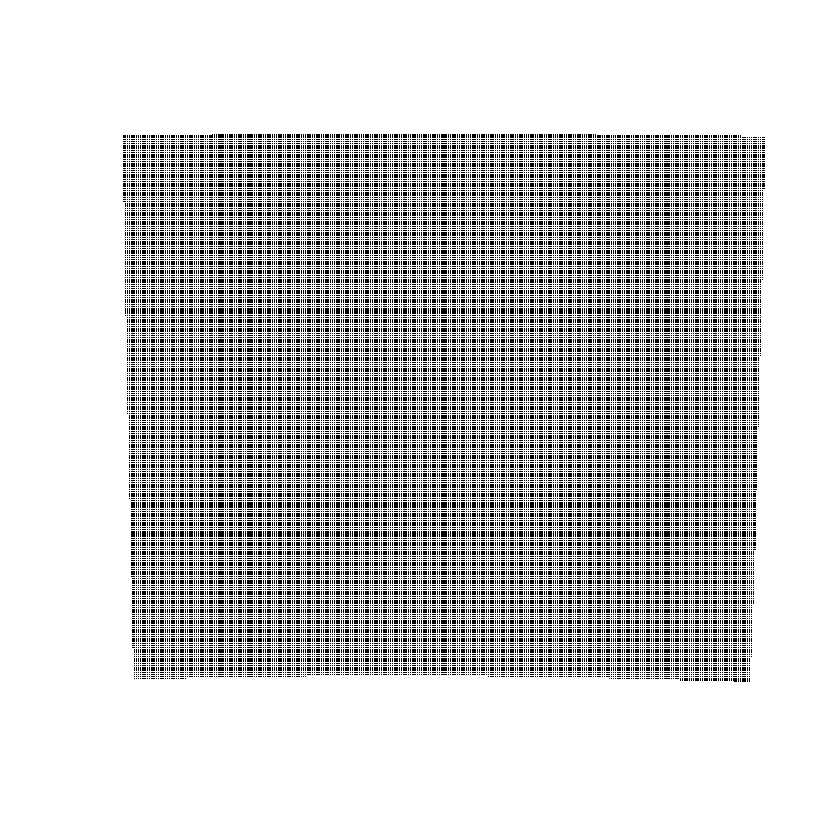

In [7]:
grid <- st_as_sf(rasterToPoints(solar, spatial=TRUE)) # uses existing raster cell centres as point locations
grid$solar <- NULL # clear existing data

plot(grid, pch=".")

In [18]:
idw <- gstat::idw(solar~x+y, df_zambian_cities_UTM35S, newdata= grid)

ERROR: Error in .local(formula, locations, ...): stars required: install that first


<br>

We'll now populate this empty grid with the x/y values and solar/altitude values

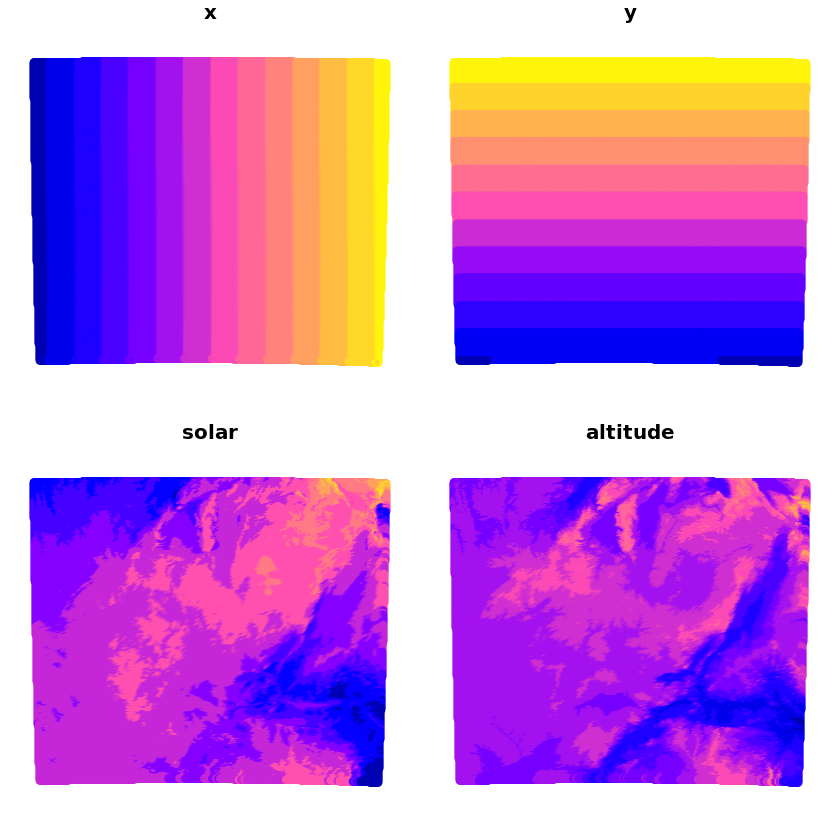

In [117]:
grid_coords <- as.data.frame(st_coordinates(grid))

grid$x <- grid_coords[, 1]
grid$y <- grid_coords[, 2]

grid$solar <- extract(solar, grid_coords[, 1:2])
grid$altitude <- extract(altitude, grid_coords[, 1:2])

plot(grid)

<br>

We can now make the prediction which we'll compare with the true solar values, we can see that whilst it captures some of the wider characteristics there are a lot of discrepancies still.

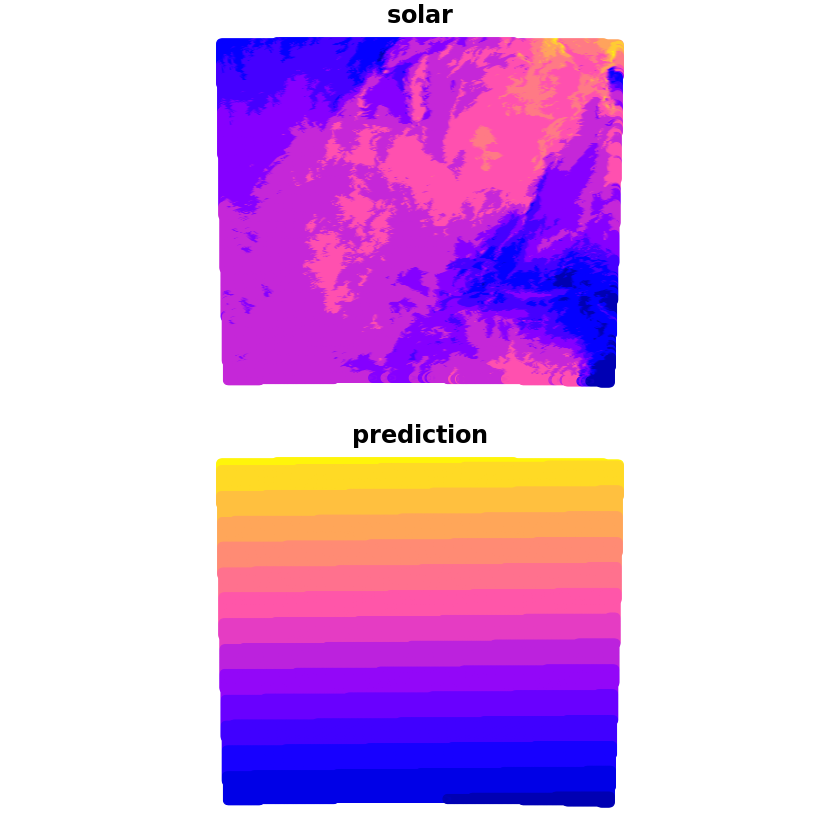

In [118]:
grid_pred <- predict(trend_1st, newdata=grid, se.fit=TRUE)
grid$prediction <- grid_pred$fit

plot(grid[c('solar', 'prediction')])

<br>

We don't just have to regress against longitude/latitude though, here we'll repeat the previous steps but only use latitude as a regressor.

First we'll visualise the relationship between the two.

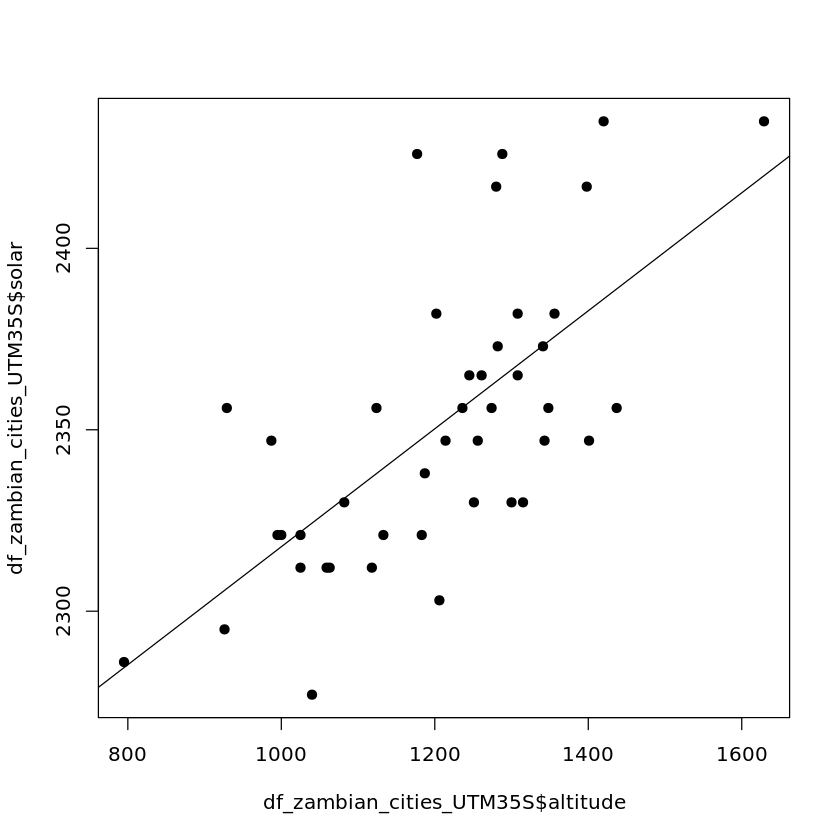

In [119]:
plot(df_zambian_cities_UTM35S$altitude, df_zambian_cities_UTM35S$solar, pch=19)
abline(lm(df_zambian_cities_UTM35S$solar ~ df_zambian_cities_UTM35S$altitude))

<br>

Then we'll fit a model and use it in our prediction.

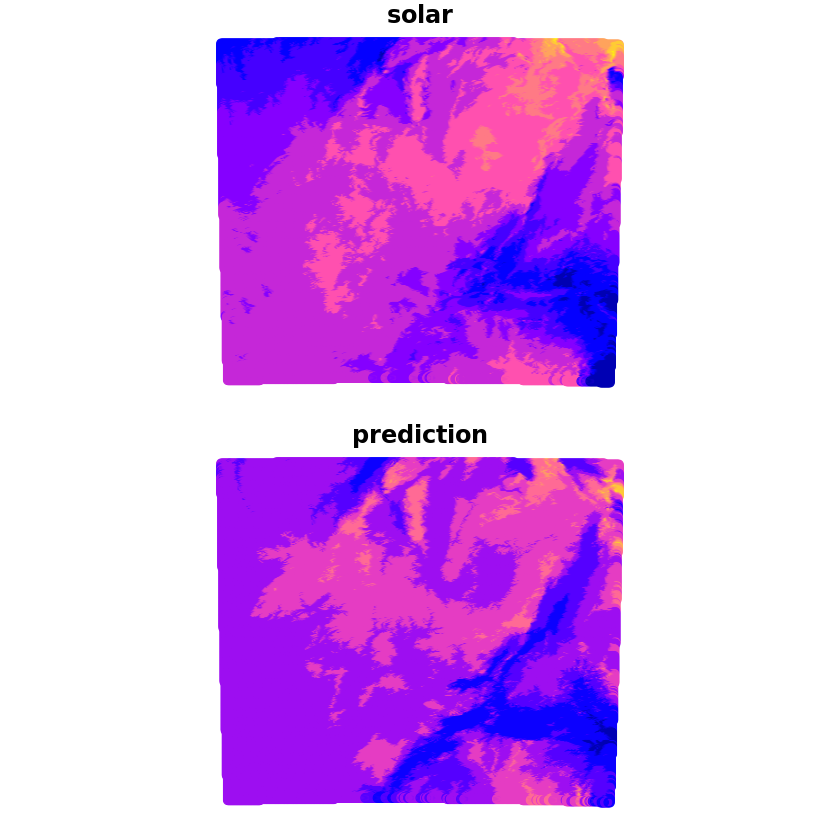

In [120]:
trend_1st <- lm(solar~altitude, data=df_zambian_cities_UTM35S)

grid_pred <- predict(trend_1st, newdata=grid, se.fit=TRUE)
grid$prediction <- grid_pred$fit

plot(grid[c('solar', 'prediction')])

<br>

### Questions

#### Best Fit Model

* What combination of the inputs produces the most accurate results? 
* Should we use the standard r2 score or the adjusted r2 score?
* How do the results change when you use a test/train split? 
* How could we improve over a random sample on the test/train split? (Think about what you would do with time-series cross-validation)

In [ ]:
# 